In [1]:
import matplotlib
%pylab inline
from scipy import stats
import pandas as pd
import os
import pickle
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
rs=42

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#interactive script to make plots for tuning RF for IMDB data

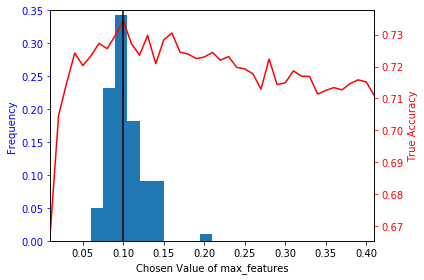

range of chosen param: 0.06-0.21
SD in performance is: 0.007645001170064776
SD in estimated performance: 0.0022162370957467576
SD of chosen param: 0.022573090701765632


In [4]:
# load in global performance for param values on held-out 49,000 datapoints
param_choices=[x/100 for x in range(1,50)]
with open ('MoviesRF_Truth', 'rb') as fp:
    Truth = pickle.load(fp)
#find the 'true' best param choice
opt=(np.argmax(Truth)+1)/100

# plot the distribution of tuned parameter values across independent runs of J-K-fold CV

#loads in precomputed prediction error estimates across the grid from 5-fold, 10-fold or 20-fold tuning

def repeatedchoicesplotter(R,K):
    #input R: is nuber of repetitions R (defined as J in paper)
    #input K: is number of folds (either 5,10 or 20)
    random.seed(rs)
    values=[]
    #load in the relevant data
    #1000 independent prediction error estimates for each parameter choice in our grid
    if (K==5):
        with open ('MoviesRF_differentpartitions_1000_5_folds', 'rb') as fp:
            results = pickle.load(fp)
        n=1000
    elif (K==10):
        with open ('MoviesRF_differentpartitions_1000_10_folds', 'rb') as fp:
            results = pickle.load(fp)
            n=1000
    elif (K==20):
        with open ('MoviesRF_differentpartitions_500_20_folds', 'rb') as fp:
            results = pickle.load(fp)
            n=500
    else:
        print("no pre-computed results")
        return
    #group each K-fold CV tuning into groups of R to have R-K-fold CV
    for i in range(0,math.floor(n/R)-1):
        means=list(results[i*R])
        #average across R K-fold CV grid searches
        for j in range(1,R):
            new=results[R*i+j]
            #for each param choice
            for k in range(0,len(results[0])):
                means[k]=means[k]+new[k]
        for k in range(0,len(results[0])):
            means[k]=means[k]/R
        values.append(means)
    repeatedchoices=[]
    for i in range(0,len(values)):
        #choose the maximum element on grid
        repeatedchoices.append((np.argmax(values[i])+1)/100)
    repeatedscores=[]
    for i in range(0,len(values)):
        repeatedscores.append((np.max(values[i])))
    #plot
    fig, ax1 = plt.subplots()
    weights = np.ones_like(repeatedchoices)/float(len(repeatedchoices))
    ax1.hist(repeatedchoices,normed=False,weights=weights, bins=np.arange(min(repeatedchoices), max(repeatedchoices) + 0.015, 0.015))
    
    ax1.set_xlabel('Chosen Value of max_features')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Frequency', color='blue')
    ax1.tick_params('y', colors='b')
    plt.ylim([0,0.35])
    ax2 = ax1.twinx()
    ax2.plot(param_choices,Truth, 'r')
    ax2.set_ylabel('True Accuracy', color='r')
    ax2.tick_params('y', colors='r')
    plt.xlim([0.01,0.41])
    plt.axvline(x=0.1,color="black")

    fig.tight_layout()
    plt.show()
    #find range in chosen params
    print("range of chosen param: "+str(min(repeatedchoices))+"-"+str(max(repeatedchoices)))
    
    #find variance in model performance
    exp_drop=0
    for i in range(0,len(repeatedchoices)):
        exp_drop= exp_drop + (np.max(Truth)-Truth[np.argmax(values[i])])*(np.max(Truth)-Truth[np.argmax(values[i])])
    exp_drop=exp_drop/(len(repeatedchoices)-1)
    print("SD in performance is: "+str(np.sqrt(exp_drop)))
    
    #find variance in estiamted model performance
    print("SD in estimated performance: "+str(np.sqrt(np.var(repeatedscores,ddof=1))))
    
    #find variance of parameter
    param_var=np.var(repeatedchoices,ddof=1)
    print("SD of chosen param: "+str(np.sqrt(param_var)))
    return values

REPS=repeatedchoicesplotter(10,10)

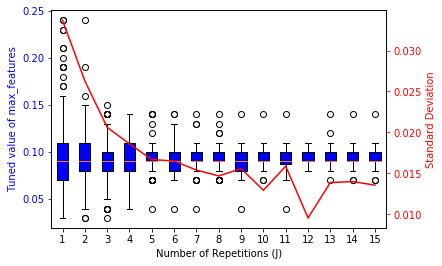

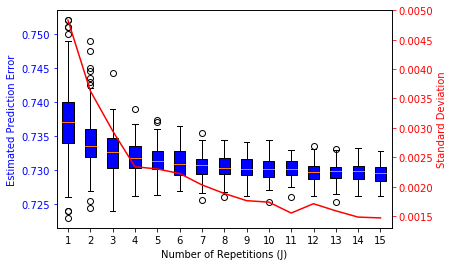

In [5]:
#Make plot of variability changing as we increase R (J in the paper)
# look at truth 


# helper function to collect choices/predictione error estimates for given R,K
def repeatedvarfinder(R,K):
    #input K: number of folds (either 5,10,20)
    #input R: number of repetitions
    values=[]
    #load in relevant data
    if (K==5):
        with open ('MoviesRF_differentpartitions_1000_5_folds', 'rb') as fp:
            results = pickle.load(fp)
        n=1000
    elif (K==10):
        with open ('MoviesRF_differentpartitions_1000_10_folds', 'rb') as fp:
            results = pickle.load(fp)
            n=1000
    elif (K==20):
        with open ('MoviesRF_differentpartitions_500_20_folds', 'rb') as fp:
            results = pickle.load(fp)
            n=500
    else:
        print("no pre-computed results")
        return
    #group each K-fold CV grid search into groups of size R to allow R-K-fold CV
    for i in range(0,math.floor(n/R)-1):
        means=list(results[i*R])
        #for each repetition
        for j in range(1,R):
            #choose other
            new=results[R*i+j]
            #for each param choice
            for k in range(0,len(results[0])):
                means[k]=means[k]+new[k]
        for k in range(0,len(results[0])):
            means[k]=means[k]/R
        values.append(means)
    repeatedchoices=[]
    for i in range(0,len(values)):
        repeatedchoices.append((np.argmax(values[i])+1)/100)
    repeatedscores=[]
    for i in range(0,len(values)):
        repeatedscores.append((np.max(values[i])))
    return[repeatedchoices,repeatedscores]
        
        
        
#function to plot         
def plotrepeatedvar(K):
    #input K: number of folds (either 5,10,20)
    param=[]
    score=[]
    param_var=[]
    score_var=[]
    #collect data for each choice of R
    for i in range(1,16):
        data=repeatedvarfinder(i,K)
        param.append(data[0])
        param_var.append(np.sqrt(np.var(data[0],ddof=1)))
        score.append(data[1])
        score_var.append(np.sqrt(np.var(data[1],ddof=1)))
    #plot
    fig, ax1 = plt.subplots()
    bp = ax1.boxplot(param, patch_artist=True)
    for patch in bp['boxes']:
            patch.set(facecolor='b')   
    ax1.set_xlabel('Number of Repetitions (J)')
    ax1.set_xticklabels([x for x in range(1,21)])
    ax1.tick_params('y', colors='b')
    ax1.set_ylabel('Tuned value of max_features', color='b')
    ax2 = ax1.twinx()
    ax2.plot([x for x in range(1,16)],param_var, 'r')
    ax2.set_ylabel('Standard Deviation', color='r')
    ax2.tick_params( colors='r')

    plt.show()
    fig, ax1 = plt.subplots()
    bp = ax1.boxplot(score,patch_artist=True)
    for patch in bp['boxes']:
            patch.set(facecolor='b')  
    ax1.set_xticklabels([x for x in range(1,16)])
    ax1.tick_params('y', colors='b')
    ax1.set_ylabel('Estimated Prediction Error', color='b')
    ax1.set_xlabel('Number of Repetitions (J)')
    ax2 = ax1.twinx()
    ax2.plot([x for x in range(1,16)],score_var, 'r')
    ax2.set_ylabel('Standard Deviation', color='r')
    ax2.tick_params( colors='r')

plotrepeatedvar(20)